<a href="https://colab.research.google.com/github/Nithyanandb/ImageEn/blob/main/UnderWaterImageEn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
#  traditional unet with modified architecture
#  all imports to be used
import matplotlib.pyplot as plt
import cv2
import numpy as np
from skimage.filters import unsharp_mask
import tensorflow as tf
import os
from keras import backend as K  # To interact with the backend (like TensorFlow)
from keras.activations import sigmoid  # Sigmoid activation function, often used in binary classification
from keras import layers
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras import initializers  # For initializing model weights
from keras.models import Sequential  # For sequential model building in Keras
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, multiply, Permute, Concatenate, Conv2D, Add, Activation, Lambda
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import load_model


In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
#  pre proccessing images
# whitebalancing, imagesharping , clahe transformation

def whitebalancenew(img):
    img_LAB = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    avg_a = np.average(img_LAB[:, :, 1])
    avg_b = np.average(img_LAB[:, :, 2])
    img_LAB[:, :, 1] = img_LAB[:, :, 1] - ((avg_a - 128) * (img_LAB[:, :, 0] / 255.0) * 1.2)
    img_LAB[:, :, 2] = img_LAB[:, :, 2] - ((avg_b - 128) * (img_LAB[:, :, 0] / 255.0) * 1.2)
    balanced_image = cv2.cvtColor(img_LAB, cv2.COLOR_LAB2BGR)
    return balanced_image


def unsharpmasking(image ,radius,amount):
    img = unsharp_mask(image=image,radius=radius,amount=amount)
    # rgbimg = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    # return rgbimg
    return img


def applyclahe(image):
    # bgr = cv2.imread("./test1.jpg")
    # print(bgr)
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l,a,b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(8,8))
    l1 = clahe.apply(l)
    lab_planes = cv2.merge((l1,a,b))
    # lab = cv2.merge(lab_planes)
    bgr = cv2.cvtColor(lab_planes, cv2.COLOR_LAB2BGR)
    rgb_img = cv2.cvtColor(bgr,cv2.COLOR_BGR2RGB)
    return rgb_img

def image_enhancement(image):
    # input will be bgr images output will be rgb enhanced images
    newwbimage = whitebalancenew(image)
    # Apply unsharp masking
    sharpened_image = unsharpmasking(newwbimage,radius=2,amount=1)
    # sharpened_image32 = sharpened_image.astype(np.float32)
    imgforclahe = (sharpened_image*255).astype(np.uint8)
    claheimg = applyclahe(imgforclahe)
    # return cv2.cvtColor(claheimg,cv2.COLOR_BGR2RGB)
    return claheimg

In [24]:
test_img = img_to_array(load_img("/content/drive/MyDrive/Colab Notebooks/44.jpg"),dtype="uint8")

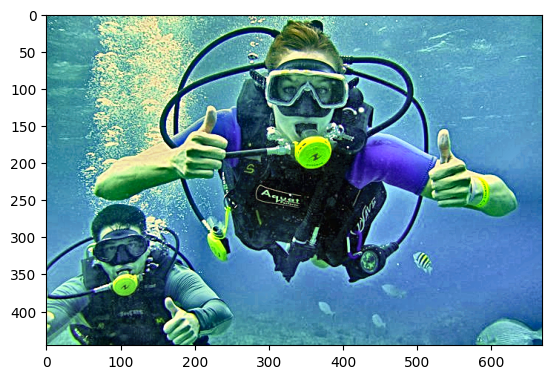

In [25]:

test_img_bgr = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR)
enhanced_img = image_enhancement(test_img_bgr)
plt.imshow(enhanced_img)

In [26]:

batch_size = 32
img_height = 256
img_width = 256
enhanced_dir = ""
blurred_dir  =""
validationdir = ''
enhanced_images = []
def get_batch_images(enhanced_dir,blurred_dir,batch_size=32,target_size=(256,256),augement = False):
  enhanced_images = sorted([os.path.join(enhanced_dir,fname)]for fname in os.listdir(enhanced_dir))
  blurred_images = sorted([os.path.join(blurred_dir,fname)] for fname in os.listdir(blurred_dir))

  assert len(enhanced_images) == len(blurred_images) , "lenght of both images arere tyhe same"


  datagen = ImageDataGenerator(horizontalflip = True,rotation_range=10, zoom_range = 0.1)

  while True:
    for i in range(0,len(enhanced_images),batch_size):
      end = min(i+batch_size,len(enhanced_images))

      enhanced_batch = []
      blurred_batch = []

      for j in range(i,end):
        enhanced_image = load_img(enhanced_images[j],target_size = target_size)
        blurred_image = load_img(blurred_images[j], target_size = target_size)

        enhanced_array = datagen.random_transform(img_to_array(enhanced_image))
        enhanced_img_bgr = cv2.cvtColor(enhanced_array, cv2.COLOR_RGB2BGR)
        enhanced_img = image_enhancement(enhanced_img_bgr)

        blurred_array = datagen.random_transform(img_to_array(blurred_image))
        blurred_img_bgr = cv2.cvtColor(blurred_array, cv2.COLOR_RGB2BGR)
        blurred_img = image_enhancement(blurred_img_bgr)

        enhanced_batch.append(enhanced_array)
        blurred_batch.append(blurred_array)



    enhanced_batch = np.array(enhanced_batch,dtype = "float32")/255.0
    blurred_batch = np.array(blurred_batch,dtype = 'float32')/255.0


    yield (blurred_batch,enhanced_batch)


In [27]:

"""
Simple Unet model
"""
# u-net model
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU

kernel_initializer =  'he_uniform'  # also try 'he_normal' but model not converging...
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

################################################################
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)



    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)

    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    print(u7.shape)
    print(c3.shape)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)

    outputs = Conv2D(3, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['accuracy'])
    #model.compile(optimizer=Adam(lr = 1e-3), loss='binary_crossentropy', metrics=[MeanIoU(num_classes=2)])
    model.summary()
    # print(u7.shape)
    # print(c3.shape)

    return model









In [28]:
model  =  simple_unet_model(128, 128, 3)
# print(model)

(None, 32, 32, 64)
(None, 32, 32, 64)


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_58 (Conv2D)        │ (None, 128, 128, 16)   │            448 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_54 (Dropout)      │ (None, 128, 128, 16)   │              0 │ conv2d_58[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_59 (Conv2D)        │ (None, 128, 128, 16)   │          2,320 │ dropout_54[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_24          │ (None, 64, 64, 16)     │              0 │ conv2d_59[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_60 (Conv2D)        │ (None, 64, 64, 32)     │          4,640 │ max_pooling2d_24[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_55 (Dropout)      │ (None, 64, 64, 32)     │              0 │ conv2d_60[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_61 (Conv2D)        │ (None, 64, 64, 32)     │          9,248 │ dropout_55[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_25          │ (None, 32, 32, 32)     │              0 │ conv2d_61[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_62 (Conv2D)        │ (None, 32, 32, 64)     │         18,496 │ max_pooling2d_25[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_56 (Dropout)      │ (None, 32, 32, 64)     │              0 │ conv2d_62[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_63 (Conv2D)        │ (None, 32, 32, 64)     │         36,928 │ dropout_56[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_26          │ (None, 16, 16, 64)     │              0 │ conv2d_63[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_64 (Conv2D)        │ (None, 16, 16, 128)    │         73,856 │ max_pooling2d_26[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_57 (Dropout)      │ (None, 16, 16, 128)    │              0 │ conv2d_64[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_65 (Conv2D)        │ (None, 16, 16, 128)    │        147,584 │ dropout_57[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_27          │ (None, 8, 8, 128)      │              0 │ conv2d_65[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 1,941,139 (7.40 MB)

 Trainable params: 1,941,139 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# making a  new cbam layer for our model to be tested
def cbam_block(cbam_feature, ratio=8): # Convolutional Block Attention Module CBAM
    """
    Convolutional Block Attention Module (CBAM) block implementation.
    Enhances the feature representation by focusing on important features in channel and spatial dimensions.
    Reference: https://arxiv.org/abs/1807.06521.
    """
    cbam_feature = channel_attention(cbam_feature, ratio)  # Apply channel attention
    cbam_feature = spatial_attention(cbam_feature)  # Apply spatial attention
    return cbam_feature

def channel_attention(input_feature, ratio=8):
    """
    Applies channel attention mechanism to the input feature map.
    Focuses on 'what' is meaningful given an input.
    """
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1  # Determine the channel axis
    channel = input_feature.shape[channel_axis]  # Get the number of channels

    # Shared MLP layers
    shared_layer_one = Dense(channel//ratio, activation='relu', kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')
    shared_layer_two = Dense(channel, kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')

    # Average pooling path
    avg_pool = GlobalAveragePooling2D()(input_feature)
    avg_pool = Reshape((1,1,channel))(avg_pool)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)

    # Max pooling path
    max_pool = GlobalMaxPooling2D()(input_feature)
    max_pool = Reshape((1,1,channel))(max_pool)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)

    # Combine features from average and max pooling paths
    cbam_feature = Add()([avg_pool, max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)

    # Adjust feature map for 'channels_first' data format
    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)

    return multiply([input_feature, cbam_feature])

def spatial_attention(input_feature):
    """
    Applies spatial attention mechanism to the input feature map.
    Focuses on 'where' is an informative part in the feature map.
    """
    kernel_size = 7  # Kernel size for the convolution operation in spatial attention

    # Adjusting input feature based on channel data format
    if K.image_data_format() == "channels_first":
        channel = input_feature.shape[1]
        cbam_feature = Permute((2,3,1))(input_feature)
    else:
        channel = input_feature.shape[-1]
        cbam_feature = input_feature

    # Apply average and max pooling
    avg_pool = Lambda(lambda x: tf.keras.backend.mean(x, axis=3, keepdims=True))(cbam_feature)
    max_pool = Lambda(lambda x: tf.keras.backend.max(x, axis=3, keepdims=True))(cbam_feature)
    concat = Concatenate(axis=3)([avg_pool, max_pool])

    # Convolution layer for spatial attention
    cbam_feature = Conv2D(filters=1, kernel_size=kernel_size, strides=1, padding='same', activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(concat)

    # Adjust feature map for 'channels_first' data format
    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)

    return multiply([input_feature, cbam_feature])

In [30]:


import tensorflow as tf

from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, Input
from tensorflow.keras.layers import Activation, Concatenate, Conv2D, Multiply

"""
Implementation of CBAM: Convolutional Block Attention Module in the TensorFlow 2.5.
Paper: https://arxiv.org/pdf/1807.06521
"""

def channel_attention_module(x, ratio=8):
    batch, _, _, channel = x.shape

    ## Shared layers
    l1 = Dense(channel//ratio, activation="relu", use_bias=False)
    l2 = Dense(channel, use_bias=False)

    ## Global Average Pooling
    x1 = GlobalAveragePooling2D()(x)
    x1 = l1(x1)
    x1 = l2(x1)

    ## Global Max Pooling
    x2 = GlobalMaxPooling2D()(x)
    x2 = l1(x2)
    x2 = l2(x2)

    ## Add both the features and pass through sigmoid
    feats = x1 + x2
    feats = Activation("sigmoid")(feats)
    feats = Multiply()([x, feats])

    return feats

def spatial_attention_module(x):
    ## Average Pooling
    x1 = tf.reduce_mean(x, axis=-1)
    x1 = tf.expand_dims(x1, axis=-1)

    ## Max Pooling
    x2 = tf.reduce_max(x, axis=-1)
    x2 = tf.expand_dims(x2, axis=-1)

    ## Concatenat both the features
    feats = Concatenate()([x1, x2])
    ## Conv layer
    feats = Conv2D(1, kernel_size=7, padding="same", activation="sigmoid")(feats)
    feats = Multiply()([x, feats])

    return feats

def CBAM1(x):
    x = channel_attention_module(x)
    x = spatial_attention_module(x)
    return x


In [31]:
import numpy as np
test = np.ones((4,128,128,3))
c = cbam_block(test)
print(c.shape)

(4, 128, 128, 3)


In [32]:

"""
Modified  Unet model with CBAM and Depth separable convulutions layers
"""

# u-net model
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda,SeparableConv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU

kernel_initializer =  'he_uniform'  # also try 'he_normal' but model not converging...
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

################################################################
def simple_unet_model1(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = SeparableConv2D(16, (3, 3), activation='relu',  padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = SeparableConv2D(16, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    cb1 = cbam_block(c1)

    c2 = SeparableConv2D(32, (3, 3), activation='relu', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = SeparableConv2D(32, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    cb2 =cbam_block(c2)

    c3 = SeparableConv2D(64, (3, 3), activation='relu', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = SeparableConv2D(64, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    cb3 = cbam_block(c3)

    c4 = SeparableConv2D(128, (3, 3), activation='relu', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = SeparableConv2D(128, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
    cb4  = cbam_block(c4)

    c5 = SeparableConv2D(256, (3, 3), activation='relu', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = SeparableConv2D(256, (3, 3), activation='relu', padding='same')(c5)

    c5 = cbam_block(c5)
    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, cb4])
    c6 = SeparableConv2D(128, (3, 3), activation='relu',  padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = SeparableConv2D(128, (3, 3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, cb3])
    c7 = SeparableConv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = SeparableConv2D(64, (3, 3), activation='relu',  padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, cb2])
    c8 = SeparableConv2D(32, (3, 3), activation='relu',  padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = SeparableConv2D(32, (3, 3), activation='relu',  padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, cb1], axis=3)
    c9 = SeparableConv2D(16, (3, 3), activation='relu', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = SeparableConv2D(16, (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(3, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['accuracy'])
    #model.compile(optimizer=Adam(lr = 1e-3), loss='binary_crossentropy', metrics=[MeanIoU(num_classes=2)])
    model.summary()

    return model









In [33]:
new_model = simple_unet_model1(128, 128, 3)
print(new_model)

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_82       │ (None, 128, 128, 16)   │             91 │ input_layer_7[0][0]    │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_63 (Dropout)      │ (None, 128, 128, 16)   │              0 │ separable_conv2d_82[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_83       │ (None, 128, 128, 16)   │            416 │ dropout_63[0][0]       │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_28          │ (None, 64, 64, 16)     │              0 │ separable_conv2d_83[0… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_84       │ (None, 64, 64, 32)     │            688 │ max_pooling2d_28[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_64 (Dropout)      │ (None, 64, 64, 32)     │              0 │ separable_conv2d_84[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_85       │ (None, 64, 64, 32)     │          1,344 │ dropout_64[0][0]       │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_29          │ (None, 32, 32, 32)     │              0 │ separable_conv2d_85[0… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_86       │ (None, 32, 32, 64)     │          2,400 │ max_pooling2d_29[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_65 (Dropout)      │ (None, 32, 32, 64)     │              0 │ separable_conv2d_86[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_87       │ (None, 32, 32, 64)     │          4,736 │ dropout_65[0][0]       │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_30          │ (None, 16, 16, 64)     │              0 │ separable_conv2d_87[0… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_88       │ (None, 16, 16, 128)    │          8,896 │ max_pooling2d_30[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 407,990 (1.56 MB)

 Trainable params: 407,990 (1.56 MB)

 Non-trainable params: 0 (0.00 B)

<Functional name=functional_7, built=True>


In [34]:
# import numpy as np

# test = np.ones((4,128,128,3))
# cbammmodel  = cbam(test)

# print(cbammmodel)


In [35]:

"""
Simple Unet model
"""
# u-net model
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda,SeparableConv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU

kernel_initializer =  'he_uniform'  # also try 'he_normal' but model not converging...
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

################################################################
def simple_unet_model2(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu',kernel_initializer = kernel_initializer,  padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu',kernel_initializer = kernel_initializer, padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    cb1 = cbam_block(c1)

    c2 = Conv2D(32, (3, 3), activation='relu',kernel_initializer = kernel_initializer, padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer = kernel_initializer, padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    cb2 =cbam_block(c2)

    c3 = SeparableConv2D(64, (3, 3), activation='relu', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = SeparableConv2D(64, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    cb3 = cbam_block(c3)

    c4 = SeparableConv2D(128, (3, 3), activation='relu', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = SeparableConv2D(128, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
    cb4  = cbam_block(c4)

    c5 = SeparableConv2D(256, (3, 3), activation='relu', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = SeparableConv2D(256, (3, 3), activation='relu', padding='same')(c5)

    c5 = cbam_block(c5)
    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, cb4])
    c6 = SeparableConv2D(128, (3, 3), activation='relu',  padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = SeparableConv2D(128, (3, 3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, cb3])
    c7 = SeparableConv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = SeparableConv2D(64, (3, 3), activation='relu',  padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, cb2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer = kernel_initializer, padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu',kernel_initializer = kernel_initializer,  padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, cb1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer = kernel_initializer,   padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu',kernel_initializer = kernel_initializer, padding='same')(c9)

    outputs = Conv2D(3, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['accuracy'])
    #model.compile(optimizer=Adam(lr = 1e-3), loss='binary_crossentropy', metrics=[MeanIoU(num_classes=2)])
    model.summary()

    return model









In [36]:
model2 = simple_unet_model2(128, 128, 3)
print(model2)

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_84 (Conv2D)        │ (None, 128, 128, 16)   │            448 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_72 (Dropout)      │ (None, 128, 128, 16)   │              0 │ conv2d_84[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_85 (Conv2D)        │ (None, 128, 128, 16)   │          2,320 │ dropout_72[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_32          │ (None, 64, 64, 16)     │              0 │ conv2d_85[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_87 (Conv2D)        │ (None, 64, 64, 32)     │          4,640 │ max_pooling2d_32[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_73 (Dropout)      │ (None, 64, 64, 32)     │              0 │ conv2d_87[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_88 (Conv2D)        │ (None, 64, 64, 32)     │          9,248 │ dropout_73[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_33          │ (None, 32, 32, 32)     │              0 │ conv2d_88[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_100      │ (None, 32, 32, 64)     │          2,400 │ max_pooling2d_33[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_74 (Dropout)      │ (None, 32, 32, 64)     │              0 │ separable_conv2d_100[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_101      │ (None, 32, 32, 64)     │          4,736 │ dropout_74[0][0]       │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_34          │ (None, 16, 16, 64)     │              0 │ separable_conv2d_101[… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_102      │ (None, 16, 16, 128)    │          8,896 │ max_pooling2d_34[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_75 (Dropout)      │ (None, 16, 16, 128)    │              0 │ separable_conv2d_102[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_103      │ (None, 16, 16, 128)    │         17,664 │ dropout_75[0][0]       │
│ (SeparableConv2D)    

 Total params: 451,531 (1.72 MB)

 Trainable params: 451,531 (1.72 MB)

 Non-trainable params: 0 (0.00 B)

<Functional name=functional_8, built=True>


In [40]:
steps_per_epoch = len(enhanced_images)//batch_size
print(steps_per_epoch)
epochs = 500
early_stopping = EarlyStopping(
    monitor='val_accuracy',   # Metric to monitor (use 'accuracy' if you're not using validation)
    patience=5,               # Number of epochs with no improvement after which training will be stopped
    verbose=1,                # Verbosity mode (1 = show messages)
    mode='max',               # 'max' because we want to maximize the monitored quantity (accuracy)
    restore_best_weights=True # Restore model weights from the epoch with the best accuracy
)

tensorboard_callback = TensorBoard(log_dir='/content/drive/MyDrive/Colab Notebooks/logs',
                                   histogram_freq=1,
                                   write_graph=True,
                                   write_images=True)

modified_unet_model = simple_unet_model1(256,256,3)
modified_unet_model.compile(optimizer)
modified_unet_model.fit(get_batch_images(enhanced_dir,blurred_dir,32),steps_per_epoch = steps_per_epoch,epochs=epochs,verbose =1,callbacks=[early_stopping,tensorboard_callback])

modified_unet_model.save("/content/drive/MyDrive/Colab Notebooks//content/driveunderwaterenhancementmodel.h5")

0


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10            │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_128      │ (None, 256, 256, 16)   │             91 │ input_layer_10[0][0]   │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_90 (Dropout)      │ (None, 256, 256, 16)   │              0 │ separable_conv2d_128[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_129      │ (None, 256, 256, 16)   │            416 │ dropout_90[0][0]       │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_40          │ (None, 128, 128, 16)   │              0 │ separable_conv2d_129[… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_130      │ (None, 128, 128, 32)   │            688 │ max_pooling2d_40[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_91 (Dropout)      │ (None, 128, 128, 32)   │              0 │ separable_conv2d_130[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_131      │ (None, 128, 128, 32)   │          1,344 │ dropout_91[0][0]       │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_41          │ (None, 64, 64, 32)     │              0 │ separable_conv2d_131[… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_132      │ (None, 64, 64, 64)     │          2,400 │ max_pooling2d_41[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_92 (Dropout)      │ (None, 64, 64, 64)     │              0 │ separable_conv2d_132[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_133      │ (None, 64, 64, 64)     │          4,736 │ dropout_92[0][0]       │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_42          │ (None, 32, 32, 64)     │              0 │ separable_conv2d_133[… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_134      │ (None, 32, 32, 128)    │          8,896 │ max_pooling2d_42[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 407,990 (1.56 MB)

 Trainable params: 407,990 (1.56 MB)

 Non-trainable params: 0 (0.00 B)

FileNotFoundError: [Errno 2] No such file or directory: ''

In [39]:
#  loading the saVED MODEL
model  = load_model("content/drive/MyDrive/Colab Notebooks/underwaterenhancementmodel.h5")

def video_enhancement(input_video_path, output_video_path, model):
    # Open the input video
    cap = cv2.VideoCapture(input_video_path)

    # Get video properties
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    codec = int(cap.get(cv2.CAP_PROP_FOURCC))
    print(fps,width,height,codec)
    count =1
    # Create a VideoWriter object to save the output video
    out = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'MJPG'), fps, (width, height))
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Process the frame (enhancement)
        enhanced_frame = image_enhancement(frame)
        enhanced_frame = cv2.cvtColor(enhanced_frame,cv2.COLOR_RGB2BGR)
        modelenhancedframe   = model.predict(enhanced_frame)

        # if count == 1 :
        #     plt.imshow(enhanced_frame)
        #     count+=1

        # Write the processed frame to the output video
        out.write(modelenhancedframe)

        if cv2.waitKey(1) & 0xFF == ord('s'):
            break

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'content/drive/MyDrive/Colab Notebooks/underwaterenhancementmodel.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)